<h1> Imports and Datasets </h1>

In [ ]:
import ast
import folium
from folium.plugins import HeatMap
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import shape, Point
from sklearn.neighbors import BallTree
from stratifiedSample import *

In [ ]:
df_transit = pd.read_excel("Transit Data - October.xlsx")
df_neighbourhoods = pd.read_csv("neighbourhoods.csv")

<h1> Data Cleaning </h1>


In [2]:
df_transit.head(10)

Date                Time   Class               Operation   Bus  Route  \
0 2017-10-01 1900-01-01 01:43:03  QUEENS              Exact Fare   620     17   
1 2017-10-01 1900-01-01 01:43:08  QUEENS              Exact Fare   620     17   
2 2017-10-01 1900-01-01 01:58:13   ADULT  Pass (Multi-ride card)   620     17   
3 2017-10-01 1900-01-01 01:58:25  QUEENS              Exact Fare   620     17   
4 2017-10-01 1900-01-01 01:58:27  QUEENS              Exact Fare   620     17   
5 2017-10-01 1900-01-01 01:58:30  QUEENS              Exact Fare   620     17   
6 2017-10-01 1900-01-01 05:47:13  QUEENS              Exact Fare  1687      7   
7 2017-10-01 1900-01-01 00:11:07  QUEENS              Exact Fare   620     17   
8 2017-10-01 1900-01-01 00:13:01  QUEENS              Exact Fare   620     17   
9 2017-10-01 1900-01-01 00:15:32  QUEENS              Exact Fare   620     17   

    Latitude  Longitude  
0  44.227860 -76.496938  
1  44.227860 -76.496938  
2  44.232035 -76.491397  
3  44.232035 -76.491397  
4  44.232035 -76.491397  
5  44.232035 -76.491397  
6  44.261297 -76.507313  
7  44.227837 -76.497027  
8  44.227317 -76.500192  
9  44.223395 -76.513757

In [3]:
df_transit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704539 entries, 0 to 704538
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       704539 non-null  datetime64[ns]
 1   Time       704539 non-null  datetime64[ns]
 2   Class      704539 non-null  object        
 3   Operation  704539 non-null  object        
 4   Bus        704539 non-null  int64         
 5   Route      704539 non-null  int64         
 6   Latitude   704539 non-null  float64       
 7   Longitude  704539 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(2), object(2)
memory usage: 43.0+ MB


<h3> Dropping Any Rows Without Long Or Lat </h3>

In [4]:
# Replace zeros in 'Latitude' or 'Longitude' with NaN, then drop rows with NaN
df_transit.replace({'Latitude': {0: pd.NA}, 'Longitude': {0: pd.NA}}, inplace=True)
df_transit.dropna(subset=['Latitude', 'Longitude'], inplace=True)
# Display the first few rows to verify changes
df_transit.head()

Date                Time   Class               Operation  Bus  Route  \
0 2017-10-01 1900-01-01 01:43:03  QUEENS              Exact Fare  620     17   
1 2017-10-01 1900-01-01 01:43:08  QUEENS              Exact Fare  620     17   
2 2017-10-01 1900-01-01 01:58:13   ADULT  Pass (Multi-ride card)  620     17   
3 2017-10-01 1900-01-01 01:58:25  QUEENS              Exact Fare  620     17   
4 2017-10-01 1900-01-01 01:58:27  QUEENS              Exact Fare  620     17   

  Latitude Longitude  
0  44.2279  -76.4969  
1  44.2279  -76.4969  
2   44.232  -76.4914  
3   44.232  -76.4914  
4   44.232  -76.4914

<h3> Converting All Class Values Into Caps </h3>

In [5]:
set(df_transit["Class"])

{'ADULT',
 'CHILD',
 'Child',
 'Commuter',
 'QUEENS',
 'SENIOR',
 'ST LAWRENCE',
 'Student',
 'Transpass',
 'YOUTH',
 'Youth'}

In [6]:
df_transit['Class'] = df_transit['Class'].str.upper()
df_transit.dtypes

Date         datetime64[ns]
Time         datetime64[ns]
Class                object
Operation            object
Bus                   int64
Route                 int64
Latitude             object
Longitude            object
dtype: object

<h3> Adding a Day Column for Stratified Sampling </h3>

In [7]:
days = [i.Date.day for i in df_transit.iloc]
df_transit["Day"] = days

<h1> Stratified Sampling Of Data </h1>

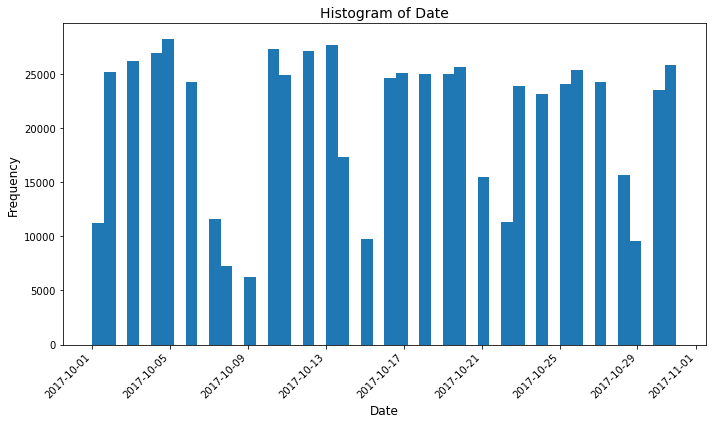

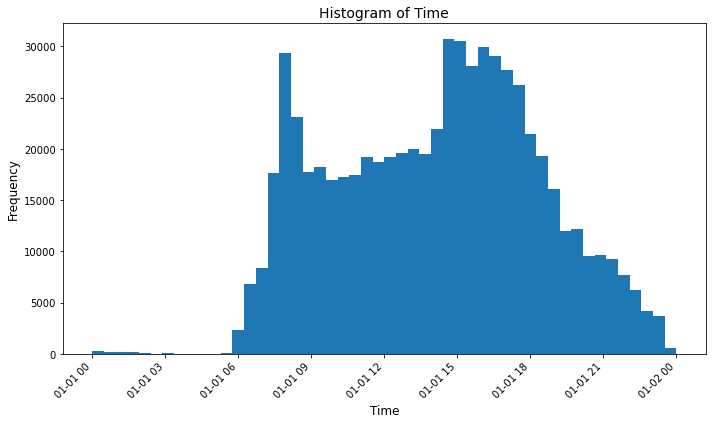

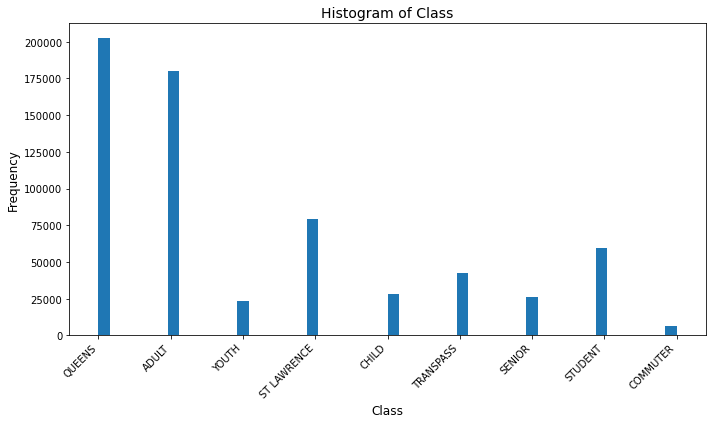

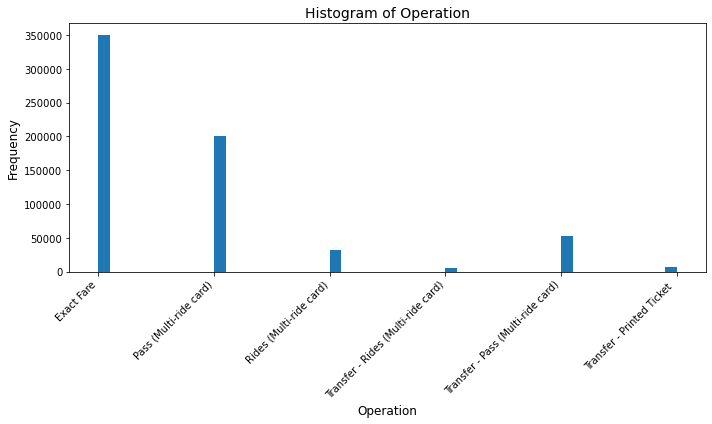

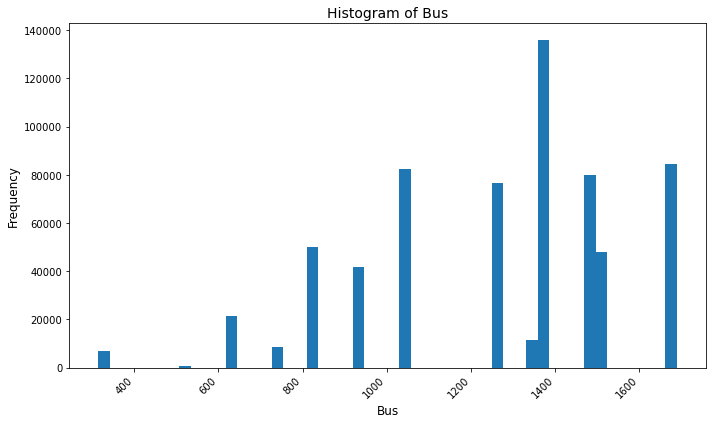

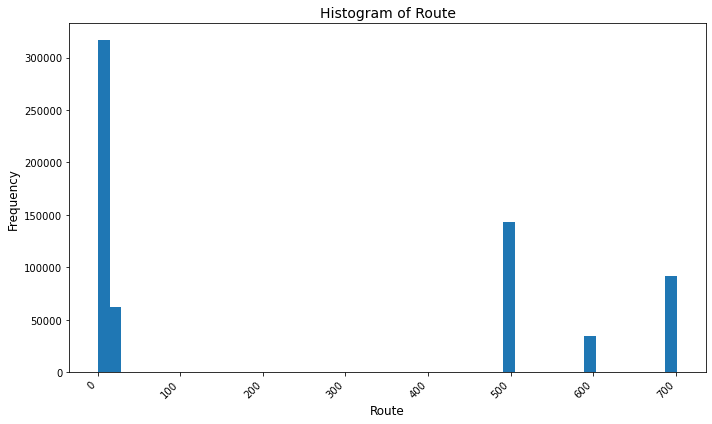

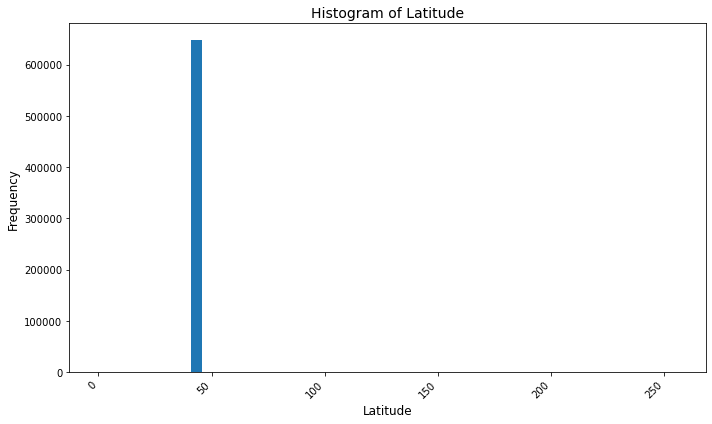

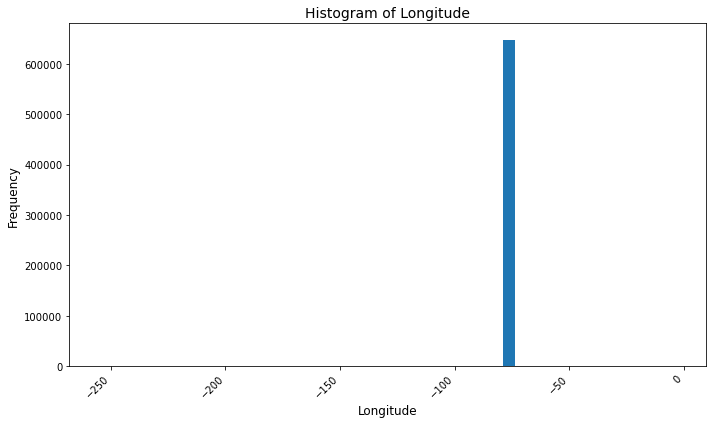

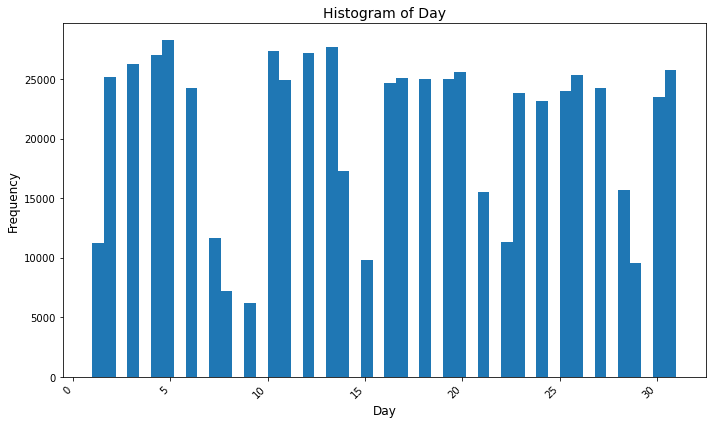

In [8]:
# Generate a histogram for each column
for column in df_transit.columns:
    plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
    df_transit[column].hist(bins=50)  # Adjust the number of bins as necessary
    plt.title(f'Histogram of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.grid(False)  # Turn off the grid for a cleaner look
    plt.show()

In [9]:
df_stratified = stratified_sample(df=df_transit, strata=['Class', 'Route', 'Day'], size=.10)

<h3> Truncating Long and Lat Column to 5 decimals (1.1 metre resolution) </h3>

In [10]:
df_stratified['Trunc Long'] = (df_stratified['Longitude'] * 10**5).astype(int) / 10**5
df_stratified['Trunc Lat'] = (df_stratified['Latitude'] * 10**5).astype(int) / 10**5

<h1> Creating a Simple plot of the Points </h1>

In [12]:
# Initialize the map
map1 = folium.Map(location=[44.2313, -76.4810], zoom_start=12, control_scale=True)
# Prepare heat data from 'stratified' DataFrame
heat_data = df_stratified[['Latitude', 'Longitude']].values.tolist()
# Add the heat data to the map
hm_wide_1 = HeatMap(heat_data,
                  radius=2,
                  blur=1,
                  min_opacity=1,
                  max_zoom=13,
                  gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'})
map1.add_child(hm_wide_1)
map1

<h1> Code To Add Neighbourhood Column To The Data </h1>

<h3> Function to Determine if a point is in given geometric bounds </h3>

In [13]:
def get_neighbourhood_name(data, point):
    # Create a Shapely point from your coordinates
    point = Point(point)
    # Check each polygon in the GeoJSON file
    for feature in data['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            # Return the neighborhood name
            return feature['properties'].get('name', 'Unknown')

    return "Point not in any neighborhood"

In [14]:
with open("neighbourhoods.geojson", 'r') as f:
    data = json.load(f)
neighbourhood_col = []
count = 0
for long, lat in zip(df_stratified["Longitude"], df_stratified["Latitude"]):
    if count%10000== 0:
        print(count)
    point = (long, lat)
    neighbourhood_name = get_neighbourhood_name(data, point)
    neighbourhood_col.append(neighbourhood_name)
    count += 1
df_stratified["Neighbourhood"] = neighbourhood_col

0
10000
20000
30000
40000
50000
60000


<h1> Neighbourhood plot </h1>

In [15]:
m = folium.Map(location=[44.2313, -76.4810], 
                 zoom_start=12, control_scale=True)
folium.GeoJson("neighbourhoods.geojson",
               tooltip=folium.GeoJsonTooltip(fields=['name'])
              ).add_to(m)
m

<h1> Creating a plot for the points with the bounds of the Kingston Neighbourhoods </h1>

In [17]:
m = folium.Map(location=[44.2313, -76.4810], 
                 zoom_start=12, control_scale=True)
folium.GeoJson("neighbourhoods.geojson",
               tooltip=folium.GeoJsonTooltip(fields=['name'])
              ).add_to(m)
# Assuming 'stratified' is a valid DataFrame with 'Latitude' and 'Longitude'
heat_data = [[row['Latitude'], row['Longitude']] for index, row in df_stratified.iterrows()]
# Adjust heatmap parameters if necessary
hm_wide = HeatMap(heat_data,
        radius=4,            # Adjust radius
        blur=1,              # Adjust blur
        min_opacity=1,      # Adjust minimum opacity
        max_zoom=13,          # Adjust max_zoom
        gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}
       )
m.add_child(hm_wide)
m

<h1> Plotting GEOJson Onto Map </h1>

In [19]:
m = folium.Map(location=[44.2313, -76.4810], 
                 zoom_start=12, control_scale=True)

In [20]:
folium.GeoJson("neighbourhoods.geojson",
               tooltip=folium.GeoJsonTooltip(fields=['name'])
              ).add_to(m)

In [21]:
df_circles = pd.read_csv("transit-gtfs-stops.csv")
with open("neighbourhoods.geojson", 'r') as f:
    data = json.load(f)
circle_col = []
count = 0
for k in df_circles["Coordinates"]:
    if count%10000== 0:
        print(count)
    coordinates_tuple = tuple(map(float, k.split(', ')))
    neighbourhood_name = get_neighbourhood_name(data, coordinates_tuple[::-1])
    circle_col.append(neighbourhood_name)
    count += 1
df_circles["Neighbourhood"] = circle_col
df_circles = df_circles[df_circles["Neighbourhood"] != "Point not in any neighborhood"]

0


In [22]:
# Initialize the map
map3 = folium.Map(location=[44.2313, -76.4810], zoom_start=12, control_scale=True)
# Add GeoJson for neighborhoods
folium.GeoJson("neighbourhoods.geojson",
               tooltip=folium.GeoJsonTooltip(fields=['name'])
              ).add_to(map3)
# Now, for each point in 'df_circles', add a circle to the map
for index, row in df_circles.iterrows():
    folium.Circle(
        location=tuple(map(float, row["Coordinates"].split(', '))),
        radius=600,  # Radius in meters
        color='yellow',
        fill=True,
        fill_color='yellow'
    ).add_to(map3)
map3

<h1> Ridership Histogram By Route </h1>


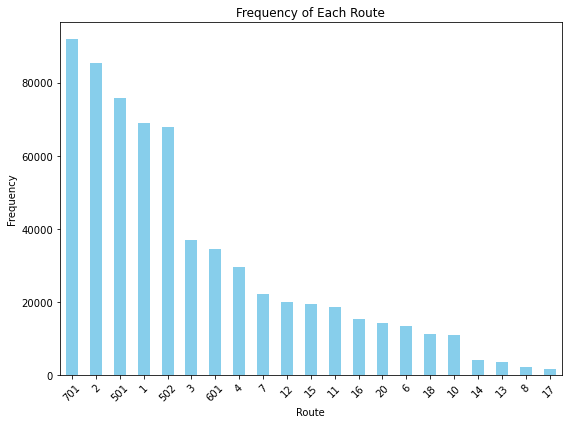

In [23]:
# Calculating the frequency of each category
category_counts = df_transit['Route'].value_counts()
# Creating the bar graph
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
category_counts.plot(kind='bar', color='skyblue')
# Rotating the labels on the x-axis for clarity
plt.xticks(rotation=45)  # Rotate labels, 45 degrees or another angle as needed
# Adding labels and title (optional)
plt.xlabel('Route')
plt.ylabel('Frequency')
plt.title('Frequency of Each Route')
# Show the plot
plt.tight_layout()  # Adjust layout if necessary
plt.show()

<h1> Plotting Transit Routes </h1>

In [24]:
# Load the CSV file
file_path = 'transit-gtfs-routes.csv'
routes_df = pd.read_csv(file_path)
# Drop the last row from the DataFrame
routes_df = routes_df[:-1]
# Initialize a map centered around the first route's coordinates to start
first_route_coords = json.loads(routes_df.iloc[0]['Shape'])['coordinates'][0][0]  # Get the first point of the first route
map_center = [first_route_coords[1], first_route_coords[0]]  # Reverse the coordinates for folium (lat, lon)
m = folium.Map(location=map_center, zoom_start=12)

# Function to plot a route on the map
def plot_route(shape_json, map_obj, line_color, label):
    coords = json.loads(shape_json)['coordinates'][0]
    folium.PolyLine(locations=[(lat, lon) for lon, lat in coords], color=f"#{line_color}", weight=10, popup=label).add_to(map_obj)
# Iterate through the routes DataFrame and plot each route
for _, row in routes_df.iterrows():
    plot_route(row['Shape'], m, row['Color'], str(row['Short Name']))
# Create a legend HTML
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 150px; height: auto; 
     background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
     ">&nbsp; <b>Route Legend</b> <br>
     %s 
</div>
''' 
# Prepare legend items
legend_items = ''
for _, row in routes_df.iterrows():
    legend_items += f'<i style="background: #{row["Color"]}; width: 18px; height: 18px; float: left; opacity: 0.7;"></i>&nbsp;{row["Short Name"]}<br>'
# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html % legend_items))
m

<h1> Creating a column with list values of cordinates </h1>

In [37]:
# Load the CSV file
routes_df = pd.read_csv('Routes.csv', nrows=28)

# Correctly convert the "Points List" column from string representations of lists to actual lists of tuples
routes_df['Points List'] = routes_df['Points List'].apply(ast.literal_eval)

# Function to calculate similarity percentage
def calculate_similarity_percentage(points_a, points_b, threshold=10):
    # Convert threshold from meters to radians for use with Haversine formula
    threshold_radians = threshold / 6371000  # Earth radius in meters
    # Create a BallTree for points_b, using Haversine distance
    tree = BallTree(np.radians(points_b), metric='haversine')
    # Query the tree for points in points_a within the threshold distance
    indices = tree.query_radius(np.radians(points_a), r=threshold_radians)
    # Calculate percentage of points_a within threshold of any point in points_b
    similarity = sum(len(ind) > 0 for ind in indices) / len(points_a)
    return similarity * 100

# Initialize an empty matrix for storing similarity percentages
n_routes = len(routes_df)
similarity_matrix = np.zeros((n_routes, n_routes))

# Compute the similarity for each pair of routes
for i in range(n_routes):
    for j in range(n_routes):
        points_a = routes_df.iloc[i]['Points List']
        points_b = routes_df.iloc[j]['Points List']
        similarity_matrix[i, j] = calculate_similarity_percentage(points_a, points_b)

# Convert the similarity matrix into a DataFrame for better readability and labeling
similarity_df = pd.DataFrame(similarity_matrix, index=routes_df['Short Name'], columns=routes_df['Short Name'])

In [38]:
df_similarity = pd.read_csv("similarity.csv")

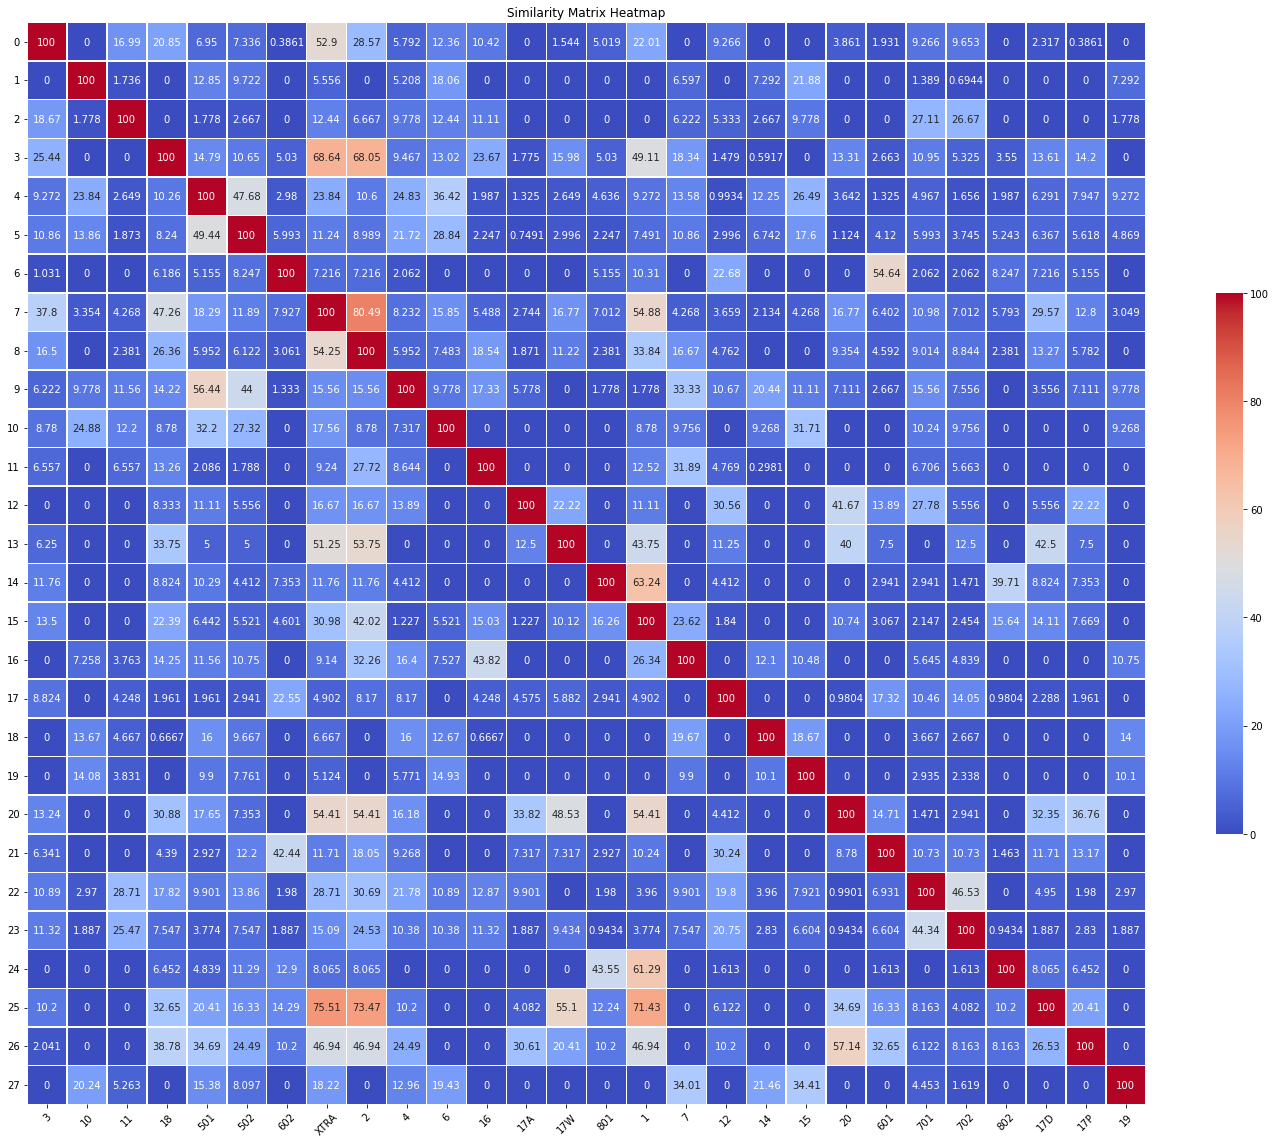

In [39]:
# Generate the heatmap
plt.figure(figsize=(20, 16))  # Set the figure size for better visibility
ax = sns.heatmap(df_similarity, cmap='coolwarm', annot=True, fmt=".4g", linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Similarity Matrix Heatmap')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal for consistency
plt.tight_layout()  # Adjust layout to make room for the label rotation
# Save the figure to a JPG file
plt.savefig('heatmap.jpg', dpi=300, bbox_inches='tight', format='jpg')
# Provide the path to the saved image
saved_image_path = 'heatmap.jpg'